In [33]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import roc_auc_score


from sklearn.datasets import make_classification

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

[-3.  -2.9 -2.8 -2.7 -2.6] ... [4.6 4.7 4.8 4.9 5. ]


Text(0.5, 1.0, 'Error Surface')

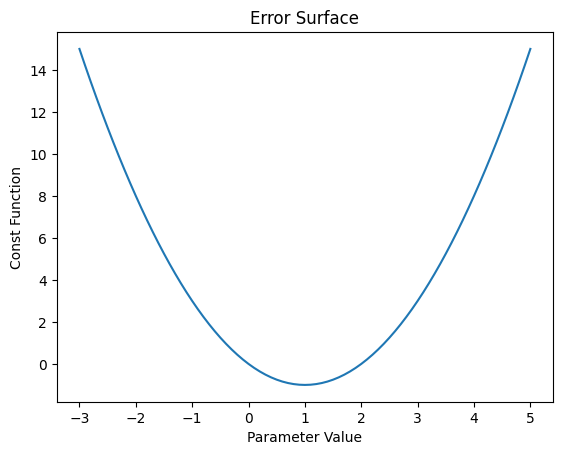

In [34]:
# Criando função que retorne o valor da função custo
X_poly = np.linspace(-3,5,81)
print(X_poly[:5], '...', X_poly[-5:])
def const_function(X):
    return X * (X-2)
y_poly = const_function(X_poly)
plt.plot(X_poly, y_poly)
plt.xlabel('Parameter Value')
plt.ylabel('Const Function')
plt.title('Error Surface')

In [35]:
# criando função para o valor do gradiente
def gradient(X):
    return (2*X) - 2
x_start = 4.5
learning_rate = 0.75
x_next = x_start - gradient(x_start)*learning_rate
x_next

-0.75

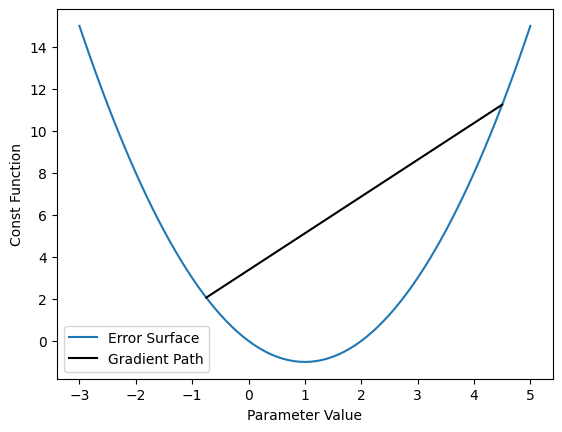

In [36]:
# plotando o caminho do gradiente descente - do ponto inciial ao próximo
plt.plot(X_poly, y_poly)
plt.plot([x_start, x_next], [const_function(x_start), const_function(x_next)], '-0')
plt.xlabel('Parameter Value')
plt.ylabel('Const Function')
plt.legend(['Error Surface', 'Gradient Path'])
plt.show()

In [37]:
# executando 14 iterações para convergir ao mínimo local da função custo
iterations = 15
x_path = np.empty(iterations,)
x_path[0] = x_start
for iteration_count in range(1,iterations):
    derivate = gradient(x_path[iteration_count-1])
    x_path[iteration_count] = x_path[iteration_count-1] - (derivate*learning_rate)
x_path

array([ 4.5       , -0.75      ,  1.875     ,  0.5625    ,  1.21875   ,
        0.890625  ,  1.0546875 ,  0.97265625,  1.01367188,  0.99316406,
        1.00341797,  0.99829102,  1.00085449,  0.99957275,  1.00021362])

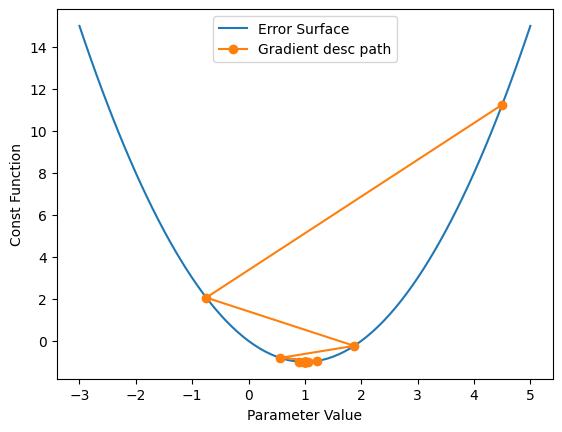

In [38]:
# plotando o caminho do gradiente descente
plt.plot(X_poly, y_poly)
plt.plot(x_path,const_function(x_path), '-o')
plt.xlabel('Parameter Value')
plt.ylabel('Const Function')
plt.legend(['Error Surface', 'Gradient desc path'])

* Uma boa maneira de aprender é repetir o procedimento anterior com diferentes taxas de aprendizado para ver como elas afetam o caminho do gradiente descendente. 
  1. A medida que se faz o teste com diferentes taxas de aprendizado, quando a taxa era maior que 1, o passo dado em direção à diminuição do erro é grande demais e acabamos obtendo um erro maior. Por outro lado, se o tamanho do passo for pequeno demais, podemors demorar para encontrar a solução desejada.

In [39]:
# Obtendo Overfitting
# Gerando dataset sintético
X_synthetic, y_synthetic = make_classification(
    n_samples=1000, n_features=200, n_informative=3, n_redundant=10, n_classes=2,
    n_repeated=0, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=0.8,
    hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=24
)
print(X_synthetic.shape, y_synthetic.shape) #examinando a dimensão do dataset

(1000, 200) (1000,)


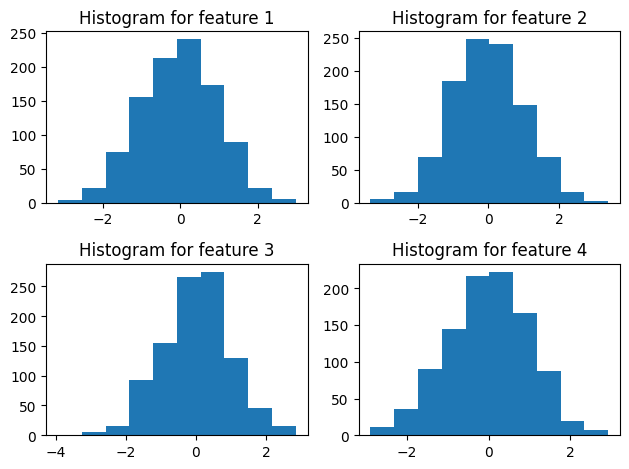

In [40]:
# plotando as primeiras características como histogramas para mostrar que o intervalo de valores é o mesmo:
for plot_index in range(4):
    plt.subplot(2,2,plot_index+1)
    plt.hist(X_synthetic[:,plot_index])
    plt.title('Histogram for feature {}'.format(plot_index+1))
plt.tight_layout()

1. Como cosntruimos o dataset não precisamos nos preocupar em balancear os dados, pois estes já estão balanceados.
2. E quanto aos relacionamentos entre características e entre estas e a variável resposta, aplicamos a REGRA de 10. Logo, por está regra não deveríamos ter mais de 50 características em nosso modelo.
3. Mesmo assim, 50 características é muito, e por isso, o modelo tende a OVERFITTAR, ou seja, performar bem para dados de treinamento e para dados de teste "patinar".

In [41]:
# dividindo os dados em treinamento e teste
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_synthetic, y_synthetic, test_size=0.20, random_state=24)
lr_syn = LogisticRegression(solver='liblinear', penalty='l1', C=1000, random_state=1)
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=1000, penalty='l1', random_state=1, solver='liblinear')

In [42]:
# calculando o resultado do treinamento
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

np.float64(0.9420000000000001)

In [43]:
# calculando o resultado do teste
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

np.float64(0.8075807580758075)

# Reduzindo o overffitng

In [44]:
# Definindo um intervalo de teste para vários valores de C
C_val_exponents = np.linspace(3, -3, 13)  # Gera 13 valores entre 3 e -3
C_vals = 10 ** C_val_exponents  # Eleva 10 aos valores gerados

# Mostrando os valores de C
print(C_vals)

[1.00000000e+03 3.16227766e+02 1.00000000e+02 3.16227766e+01
 1.00000000e+01 3.16227766e+00 1.00000000e+00 3.16227766e-01
 1.00000000e-01 3.16227766e-02 1.00000000e-02 3.16227766e-03
 1.00000000e-03]


1. Geralmente é uma boa ideia variar o parâmetro de regularização de acordo com potências de 10, já que treinar modelos pdoe demorar muito, principalmente com a utilização da validação cruzada k-folds. 

In [45]:
# definindo uma função para realizar o cross-validation
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    # Criando arrays NumPy para armazenar os valores de ROC AUC para treino e teste
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    
    # Criando uma lista de listas vazia para armazenar as curvas ROC
    cv_test_roc = [[] for _ in range(len(C_vals))]
    
    # Loop sobre cada valor de C
    for c_val_counter in range(len(C_vals)):
        # Definir o valor de C para o modelo
        model.set_params(C=C_vals[c_val_counter])
        
        # Contador de folds
        fold_counter = 0
        
        # Fazendo o cross-validation para cada fold
        for train_index, test_index in k_folds.split(X, Y):
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            
            # Ajustando o modelo com os dados de treinamento
            model.fit(X_cv_train, y_cv_train)
            
            # Prevendo probabilidades de treinamento
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:, 1])
            
            # Prevendo probabilidades de teste
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:, 1])
            
            # Obtendo as curvas ROC de teste para cada fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:, 1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            # Incrementando o contador de fold
            fold_counter += 1
        
        print(f'Done with C = {C_vals[c_val_counter]}')
    
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc


In [48]:
kf = KFold(n_splits=3)  # Criando um objeto KFold com 3 splits
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search(kf, C_vals, lr_syn, X_syn_train, y_syn_train)

Done with C = 1000.0
Done with C = 316.22776601683796
Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001


In [54]:
cmap = plt.get_cmap("tab20")  # Você pode mudar para outro colormap, como 'viridis'

Text(0.5, 1.0, 'Cross Validation scores for each fold')

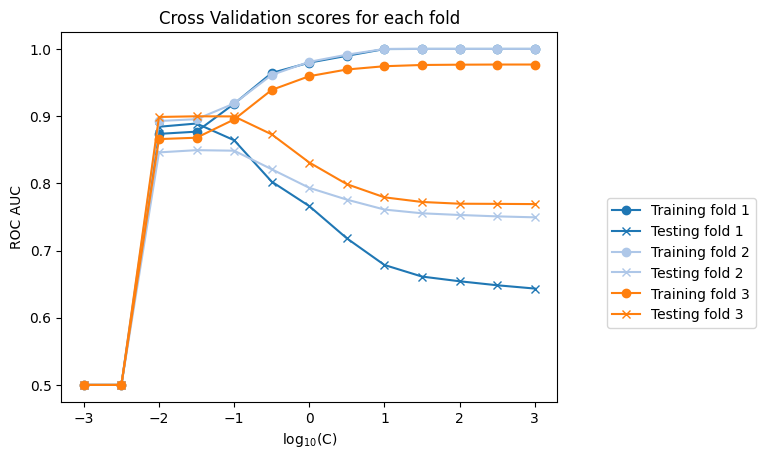

In [55]:
for this_fold in range(n_folds):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o',
             color=cmap(this_fold), label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x',
             color=cmap(this_fold), label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross Validation scores for each fold')

1. Parece que a regularização resolveu com sucesso o problema de overfiting. 
2. No entanto, quanto aos valores mais baixos de C a métrica ROC AUC cai repentinamente para 0.5. Este modelo de classificação é inútil, pois não é melhor do que jogar uma moeda para cima. 

Text(0.5, 1.0, 'Cross validation score averaged across folds')

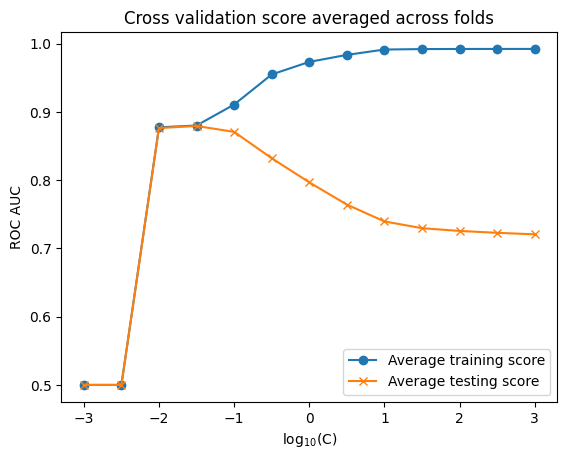

In [56]:
# plotando a média de resultados ROC AU de treinamento e teste para cada C
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',  # linha azul para treinamento
         label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',  # linha vermelha para teste
         label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation score averaged across folds')

1. Fica claro que C = -1.5 e -2 são os melhores valores para C. Há pouco ou nenhum overfitting aqui, já que resultados da média de treinamento e teste são quase iguais. 
2. Em um modelo real, é útil examinar as curvas ROC dos diferentes folds da validação cruzada. 

In [57]:
# usando array booleano para encontrar um indice onde C = -1.5
best_C_val_bool = C_val_exponents == -1.5
best_C_val_bool.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [58]:
best_C_val_ix = np.nonzero(best_C_val_bool.astype(int)) 
best_C_val_ix[0][0]

np.int64(9)

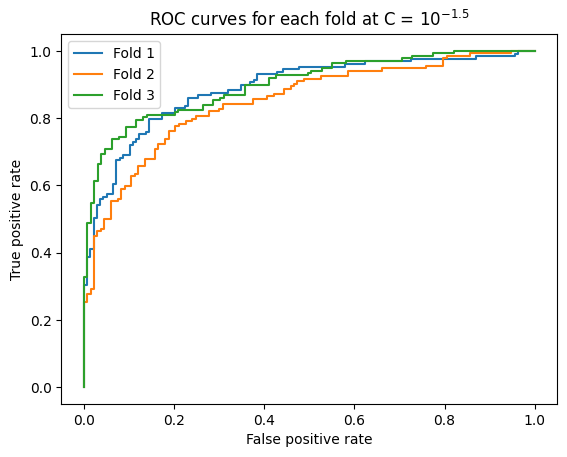

In [59]:
# acessando as taxas de verdadeiros e falsos positivos para plotar as curvas ROC de cada fold
for this_fold in range(n_folds):
    fpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][0]
    tpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(this_fold+1))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curves for each fold at C = $10^{-1.5}$')
    plt.legend()

In [62]:
# treinando o modelo com o melhor valor de C
lr_syn = LogisticRegression(solver='liblinear', penalty='l1', C=10**-1.5)
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=0.03162277660168379, penalty='l1', solver='liblinear')

In [63]:
# obtendo as probabilidades previstas e o resultado da ROC AUC para os dados de treinamento
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

np.float64(0.88029375)

In [64]:
# obtendo as probabilidades previstas e o resultado da ROC AUC para os dados de teste
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

np.float64(0.8847884788478848)

1. Com o uso da regularização, os resultados de treinamento e teste do modelo são semelhantes, indicando que o problema de overfitting foi resolvido. 
2. No mundo real, antes de distribuir esse modelo para produção, provavelmente você o treinaria com todos os dados que recebeu, inclusive o conjunto de teste desconhecido. Esse comportamento se baseia novamente na ideia de que, quanto maior o número de dados que um modelo vê, melhor deve ser seu desempenho na prática. 

In [65]:
# acessando os coeficientes do modelo treinado e determinando quantos não são zero
sum((lr_syn.coef_ != 0)[0])

np.int64(2)

In [66]:
# examinando o valor da interceptação
lr_syn.intercept_

array([0.])

1. Só 2 das 200 caracteristicas foram selecionadas
2. A interceptação foi regularizada com 0